# MNIST - Denoising autoencoder

Trains a denoising autoencoder on MNIST dataset.

Denoising is one of the classic applications of autoencoders. The denoising process removes unwanted noise that corrupted the true signal.

Noise + Data ---> Denoising Autoencoder ---> Data

Given a training dataset of corrupted data as input and true signal as output, a denoising autoencoder can recover the hidden structure to generate clean data.

This example has modular design. The encoder, decoder and autoencoder are 3 models that share weights. For example, after training the autoencoder, the encoder can be used to  generate latent vectors of input data for low-dim visualization like PCA or TSNE.

In [2]:
import keras
from keras.layers import Activation, Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

/Users/neillee/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
np.random.seed(1337)

In [4]:
# MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data()

In [5]:
image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [6]:
# Generate corrupted MNIST images by adding noise with normal dist
# centered at 0.5 and std=0.5
noise = np.random.normal(loc=0.5, scale=0.5, size=x_train.shape)
x_train_noisy = x_train + noise
noise = np.random.normal(loc=0.5, scale=0.5, size=x_test.shape)
x_test_noisy = x_test + noise

In [7]:
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [9]:
# Network parameters
input_shape = (image_size, image_size, 1)
batch_size = 128
kernel_size = 3
latent_dim = 16

In [10]:
# Encoder/Decoder number of CNN layers and filters per layer
layer_filters = [32, 64]

In [11]:
# Build the Autoencoder Model
# First build the Encoder Model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs

In [12]:
# Stack of Conv2D blocks
# Notes:
# 1) Use Batch Normalization before ReLU on deep networks
# 2) Use MaxPooling2D as alternative to strides>1
# - faster but not as good as strides>1
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               activation='relu',
               padding='same')(x)

In [13]:
# Shape info needed to build Decoder Model
shape = K.int_shape(x)

In [14]:
# Generate the latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

In [15]:
# Instantiate Encoder Model
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 16)                50192     
Total params: 69,008
Trainable params: 69,008
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Build the Decoder Model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

# Stack of Transposed Conv2D blocks
# Notes:
# 1) Use Batch Normalization before ReLU on deep networks
# 2) Use UpSampling2D as alternative to strides>1
# - faster but not as good as strides>1
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=2,
                        activation='relu',
                        padding='same')(x)

x = Conv2DTranspose(filters=1,
                    kernel_size=kernel_size,
                    padding='same')(x)

outputs = Activation('sigmoid', name='decoder_output')(x)

# Instantiate Decoder Model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 3136)              53312     
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 28, 28, 1)         289       
_________________________________________________________________
decoder_output (Activation)  (None, 28, 28, 1)         0         
Total para

In [19]:
# Autoencoder = Encoder + Decoder
# Instantiate Autoencoder Model
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
encoder (Model)              (None, 16)                69008     
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         108993    
Total params: 178,001
Trainable params: 178,001
Non-trainable params: 0
_________________________________________________________________


In [20]:
autoencoder.compile(loss='mse', optimizer='adam')

In [21]:
# Train the autoencoder
autoencoder.fit(x_train_noisy,
                x_train,
                validation_data=(x_test_noisy, x_test),
                epochs=30,
                batch_size=batch_size)

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 181s 3ms/step - loss: 0.0592 - val_loss: 0.0325
Epoch 2/30
60000/60000 [==============================] - 171s 3ms/step - loss: 0.0264 - val_loss: 0.0225
Epoch 3/30
60000/60000 [==============================] - 161s 3ms/step - loss: 0.0214 - val_loss: 0.0199
Epoch 4/30
60000/60000 [==============================] - 190s 3ms/step - loss: 0.0195 - val_loss: 0.0190
Epoch 5/30
60000/60000 [==============================] - 163s 3ms/step - loss: 0.0185 - val_loss: 0.0180
Epoch 6/30
60000/60000 [==============================] - 159s 3ms/step - loss: 0.0178 - val_loss: 0.0175
Epoch 7/30
60000/60000 [==============================] - 229s 4ms/step - loss: 0.0173 - val_loss: 0.0172
Epoch 8/30
60000/60000 [==============================] - 239s 4ms/step - loss: 0.0169 - val_loss: 0.0168
Epoch 9/30
60000/60000 [==============================] - 191s 3ms/step - loss: 0.0166 - val_loss: 0.0

In [22]:
# Predict the Autoencoder output from corrupted test images
x_decoded = autoencoder.predict(x_test_noisy)

In [23]:
# Display the 1st 8 corrupted and denoised images
rows, cols = 10, 30
num = rows * cols
imgs = np.concatenate([x_test[:num], x_test_noisy[:num], x_decoded[:num]])
imgs = imgs.reshape((rows * 3, cols, image_size, image_size))
imgs = np.vstack(np.split(imgs, rows, axis=1))
imgs = imgs.reshape((rows * 3, -1, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
imgs = (imgs * 255).astype(np.uint8)

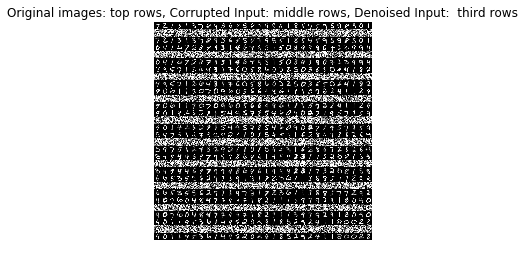

In [24]:
plt.figure()
plt.axis('off')
plt.title('Original images: top rows, '
          'Corrupted Input: middle rows, '
          'Denoised Input:  third rows')
plt.imshow(imgs, interpolation='none', cmap='gray')
Image.fromarray(imgs).save('corrupted_and_denoised.png')
plt.show()